In [1]:
import os
import cv2
import copy
import json
import numpy as np
from tqdm import tqdm

from skimage import measure
from pycocotools import mask

import matplotlib.pyplot as plt

In [2]:
base_data_path = '/home/singhv04/Desktop/nference/data/CoNIC challenge/google drive/'

In [3]:
images_data = np.load(base_data_path +'images.npy')
labels_data = np.load(base_data_path +'labels.npy')

In [4]:
images_data.shape

(4981, 256, 256, 3)

In [5]:
labels_data.shape

(4981, 256, 256, 2)

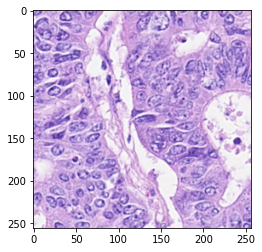

In [6]:
plt.imshow(images_data[0])

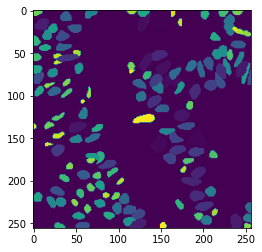

In [7]:
plt.imshow(labels_data[0][:,:,0])

In [ ]:
for j in range(0,len(images_data)):
    cv2.imwrite("temp.jpg",images_data[j])
    mask_data = labels_data[j][:,:,0]
    mask_inst  = copy.deepcopy(mask_data)
    nuceli_inst = np.unique(mask_data)

    image1 = cv2.imread("temp.jpg")
    image2 = cv2.imread("temp.jpg")

    for i in range(1,len(nuceli_inst)):
        inst = nuceli_inst[i]

        mask_copy = copy.deepcopy(mask_inst)
        mask_copy[mask_copy!=i] = 0
        mask_copy[mask_copy==i] = 255

        mask_inst_copy = copy.deepcopy(mask_copy)
        mask_inst_copy = np.array(mask_inst_copy, dtype=np.uint8)

        fortran_ground_truth_binary_mask = np.asfortranarray(mask_inst_copy)
        encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)

        ground_truth_area = mask.area(encoded_ground_truth)
        ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
        x, y, w, h = ground_truth_bounding_box
        # print(x,y ,w, h)
        
        x=int(x)
        y=int(y)
        w=int(w)
        h=int(h) 

        image1 = cv2.rectangle(image1, (x,y), (x+w,y+h), (0,255,0), 1)

        ann = []
        contours = measure.find_contours(fortran_ground_truth_binary_mask, 0.5)
        for contour in contours:
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
            ann.append(segmentation)
        
        x = [ann[0][a] for a in range(0,len(ann[0])) if a%2==0]
        y = [ann[0][a] for a in range(0,len(ann[0])) if a%2!=0]
        coords = [[a,b] for a,b in zip(x,y)]
        poly = np.array([coords], np.int32)

        image2 = cv2.polylines(image2, [poly], True, (0,0,255), 2)

    cv2.imshow("Xbox",image1)

    cv2.imshow("Xpoly",image2)
    cv2.waitKey()


    cv2.destroyAllWindows()

In [ ]:
len(images_data)

## CONIC DATASET

In [ ]:
base_img_path = "conic_data_decoded/"
# os.mkdir(base_img_path)
data = {}

In [ ]:
for j in tqdm(range(0,len(images_data))):
    img_name =  str(j)+".jpg"
    cv2.imwrite(base_img_path +img_name, images_data[j])
    cv2.imwrite("temp.jpg",images_data[j])
    mask_data = labels_data[j][:,:,0]
    mask_inst  = copy.deepcopy(mask_data)
    nuceli_inst = np.unique(mask_data)

    image1 = cv2.imread("temp.jpg")
    image2 = cv2.imread("temp.jpg")

    poly_data = []
    bbox_data = []

    for i in range(1,len(nuceli_inst)):
        inst = nuceli_inst[i]

        mask_copy = copy.deepcopy(mask_inst)
        mask_copy[mask_copy!=i] = 0
        mask_copy[mask_copy==i] = 255

        mask_inst_copy = copy.deepcopy(mask_copy)
        mask_inst_copy = np.array(mask_inst_copy, dtype=np.uint8)

        fortran_ground_truth_binary_mask = np.asfortranarray(mask_inst_copy)
        encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)

        ground_truth_area = mask.area(encoded_ground_truth)
        ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
        x, y, w, h = ground_truth_bounding_box
        # print(x,y ,w, h)
        
        x=int(x)
        y=int(y)
        w=int(w)
        h=int(h) 
        bbox_data.append([x,y,w,h])

        image1 = cv2.rectangle(image1, (x,y), (x+w,y+h), (0,255,0), 1)

        ann = []
        contours = measure.find_contours(fortran_ground_truth_binary_mask, 0.5)
        for contour in contours:
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
            ann.append(segmentation)
        
        x = [ann[0][a] for a in range(0,len(ann[0])) if a%2==0]
        y = [ann[0][a] for a in range(0,len(ann[0])) if a%2!=0]
        coords = [[a,b] for a,b in zip(x,y)]
        poly = np.array([coords], np.int32)

        image2 = cv2.polylines(image2, [poly], True, (0,0,255), 2)

        poly_data.append(poly.tolist()[0])


    # cv2.imshow("Xbox",image1)

    # cv2.imshow("Xpoly",image2)
    # cv2.waitKey()


    # cv2.destroyAllWindows()
    data[img_name] = {"count": len(bbox_data),"bbox": bbox_data, "contours": poly_data}


In [ ]:
with open("conic_data.json", "w") as outfile:
    json.dump(data, outfile)

## MERGE DATA AND CHANGE ANNOTATION ACCORDINGLY

In [8]:
def convert(size, box):
    """
    size : (width, height)
    box : [x,y,w,h]
    """
    dw = 1./size[0]
    dh = 1./size[1]
    x = box[0] + (box[2])/2.0 #centroid x
    y = box[1] + (box[3])/2.0 #centroid y
    w = box[2]
    h = box[3]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [9]:
def combine(batch_img,batch_bbox):
    im_r1 = cv2.hconcat([batch_img[0],batch_img[1]])
    im_r2 = cv2.hconcat([batch_img[2],batch_img[3]])
    final_img = cv2.vconcat([im_r1,im_r2])

    new_bbox = []
    for i in range(0,len(batch_bbox)):
        if i==0:
            for j in range(0,len(batch_bbox[i])):
                temp = batch_bbox[i][j]
                new_bbox.append(temp)
        elif i==1:
            for j in range(0,len(batch_bbox[i])):
                temp = batch_bbox[i][j]
                temp[0]+=256
                new_bbox.append(temp)
        elif i==2:
            for j in range(0,len(batch_bbox[i])):
                temp = batch_bbox[i][j]
                temp[1]+=256
                new_bbox.append(temp)
        elif i==3:
            for j in range(0,len(batch_bbox[i])):
                temp = batch_bbox[i][j]
                temp[0]+=256
                temp[1]+=256
                new_bbox.append(temp)
    #print(len(new_bbox))
    return final_img,new_bbox

In [10]:
def yolo_format(new_bbox,base_label_path,filename,label=0,width=512,height=512):
    y_f=""
    for i in range(0,len(new_bbox)):
        x,y,w,h = convert((width,height), new_bbox[i])        
        yolo_format = [str(label),str(x),str(y),str(w),str(h)]
        if y_f!="":
            y_f=y_f+"\n"+(" ".join(yolo_format))
        else:
            y_f=y_f+(" ".join(yolo_format))
    if y_f.strip()=="":
        print(filename)
        return False
    else:        
        file1 = open(base_label_path+filename+'.txt',"w")
        file1.write(y_f)
        file1.close()
        return True

In [11]:
len(images_data)

4981

In [12]:
def save_combined(new_bbox,image,name):
    for nb in new_bbox:
        x,y,w,h = nb
        image = cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 1)

    cv2.imwrite("combined/"+name, image)

In [13]:
# for j in range(0,len(images_data)):
img_counter = 0
base_label_path = "yolo_format/labels/"
base_image_path = "yolo_format/Images/"
base_dummy_path = "yolo_format/dummy/"

for k in tqdm(range(0,len(images_data),4)):
    batch_img = []
    batch_img_index = []
    batch_bbox = []
    temp_img_index = []
    for j in range(k,k+4):
        if j>=len(images_data):
            print("Completed cycle of 4, current value of j:",j)
            break
        temp_img_index.append(j)
        batch_img.append(images_data[j])
        cv2.imwrite("temp.jpg",images_data[j])
        mask_data = labels_data[j][:,:,0]
        mask_inst  = copy.deepcopy(mask_data)
        nuceli_inst = np.unique(mask_data)

        image1 = cv2.imread("temp.jpg")
        image2 = cv2.imread("temp.jpg")

        poly_data = []
        bbox_data = []

        for i in range(1,len(nuceli_inst)):
            inst = nuceli_inst[i]

            mask_copy = copy.deepcopy(mask_inst)
            mask_copy[mask_copy!=i] = 0
            mask_copy[mask_copy==i] = 255

            mask_inst_copy = copy.deepcopy(mask_copy)
            mask_inst_copy = np.array(mask_inst_copy, dtype=np.uint8)

            fortran_ground_truth_binary_mask = np.asfortranarray(mask_inst_copy)
            encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)

            ground_truth_area = mask.area(encoded_ground_truth)
            ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
            x, y, w, h = ground_truth_bounding_box
            # print(x,y ,w, h)
            
            x=int(x)
            y=int(y)
            w=int(w)
            h=int(h) 
            bbox_data.append([x,y,w,h])

            #image1 = cv2.rectangle(image1, (x,y), (x+w,y+h), (0,255,0), 1)

        batch_bbox.append(bbox_data)
    # cv2.imshow("Xbox",image1)

    # cv2.imshow("Xpoly",image2)
    # cv2.waitKey()
    batch_img_index.append(temp_img_index)
    img_counter+=1

    # cv2.destroyAllWindows()
    final_img,new_bbox = combine(batch_img,batch_bbox)
    final_img_copy = copy.deepcopy(final_img)
    save_combined(new_bbox,final_img_copy,str(img_counter)+".jpg")
    status = yolo_format(new_bbox,base_label_path,str(img_counter))
    if not status:
        print(batch_img_index, new_bbox)
        temp_name = '_'.join([str(x) for x in batch_img_index[0]]) 
        cv2.imwrite(base_dummy_path+str(img_counter)+"__"+temp_name+".jpg",final_img)
        if new_bbox!=[]:
            print("Error new box coordinates found")
    else:
        cv2.imwrite(base_image_path+str(img_counter)+".jpg",final_img)    

 14%|█▍        | 173/1246 [00:14<00:55, 19.29it/s]

174
[[692, 693, 694, 695]] []
175
[[696, 697, 698, 699]] []
176
[[700, 701, 702, 703]] []


 16%|█▌        | 199/1246 [00:16<01:04, 16.11it/s]

195
[[776, 777, 778, 779]] []
196
[[780, 781, 782, 783]] []


 22%|██▏       | 268/1246 [00:24<01:02, 15.76it/s]

265
[[1056, 1057, 1058, 1059]] []


 29%|██▉       | 359/1246 [00:34<00:51, 17.37it/s]

358
[[1428, 1429, 1430, 1431]] []


 37%|███▋      | 465/1246 [00:45<00:48, 16.07it/s]

463
[[1848, 1849, 1850, 1851]] []
464
[[1852, 1853, 1854, 1855]] []


 38%|███▊      | 478/1246 [00:46<00:50, 15.34it/s]

476
[[1900, 1901, 1902, 1903]] []


 44%|████▍     | 552/1246 [00:54<00:40, 17.19it/s]

548
[[2188, 2189, 2190, 2191]] []
549
[[2192, 2193, 2194, 2195]] []


100%|█████████▉| 1245/1246 [02:23<00:00,  8.67it/s]


Completed cycle of 4, current value of j: 4981


IndexError: list index out of range

## CHECK YOLO FORMAT

In [28]:
test_images = os.listdir("yolo_format/Images")
test_labels = os.listdir("yolo_format/labels")

In [29]:
import random
import cv2

In [30]:
sample_images = random.sample(test_images, 25)
sample_labels = [x.split(".")[0]+".txt" for x in sample_images]

In [31]:
sample_images.sort()
sample_labels.sort()

In [32]:
print(sample_labels[0],sample_images[0])

1014.txt 1014.jpg


In [33]:
def convert_yolo2gt(label, width=512, height=512):
    temp_label = []
    for k in range(0,len(label)):
        _,dx,dy,dw,dh = label[k]
        w = dw*width
        h = dh*height
        x = (dx*width) - (w/2)
        y = (dy*height) - (h/2)
        temp_label.append([x,y,w,h])
    return temp_label

In [34]:
f_img=None
for i in range(0,len(sample_images)):
    print(i)
    print(sample_images[i])
    print(sample_labels[i])
    label = []
    file = open("yolo_format/labels/"+sample_labels[i], 'r')
    for l in file:
        temp=l.split(" ")
        temp=[float(x) for x in temp]
        label.append(temp)
    
    label_data = convert_yolo2gt(label,width=512,height=512)

    img = cv2.imread("yolo_format/Images/"+sample_images[i])

    for j in range(0,len(label_data)):
        x,y,w,h = label_data[j]
        x=int(x)
        y=int(y)
        w=int(w)
        h=int(h)
        img = cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 1)

    cv2.putText(img,sample_images[i],(50,50),1,1,(0,0,255),2)
    if f_img is None:
        f_img = img
    else:
        f_img = cv2.vconcat([f_img,img])

0
1014.jpg
1014.txt
1
1068.jpg
1068.txt
2
1174.jpg
1174.txt
3
1218.jpg
1218.txt
4
136.jpg
136.txt
5
138.jpg
138.txt
6
181.jpg
181.txt
7
202.jpg
202.txt
8
24.jpg
24.txt
9
264.jpg
264.txt
10
288.jpg
288.txt
11
315.jpg
315.txt
12
334.jpg
334.txt
13
366.jpg
366.txt
14
4.jpg
4.txt
15
410.jpg
410.txt
16
440.jpg
440.txt
17
462.jpg
462.txt
18
539.jpg
539.txt
19
545.jpg
545.txt
20
590.jpg
590.txt
21
637.jpg
637.txt
22
655.jpg
655.txt
23
804.jpg
804.txt
24
865.jpg
865.txt


In [35]:
cv2.imwrite("tested_format.jpg",f_img)

True

In [11]:
# cv2.imshow("img",f_img)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [ ]:
"""
merge 4 images
1st coord : no change
2nd coord : add 256 to x
3rd coord : add 256 to y
4th coord : add 256 in each of the axis 
"""